<a href="https://colab.research.google.com/github/pranshudatascience/Animal-Faces-Identification/blob/main/Animal_Faces_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [17]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

# **Loading our Dataset via Kaggle** 

In [18]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"datasciencepranshu","key":"f206fef76574e388b3dba86a1861be62"}'}

In [19]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [20]:
!kaggle datasets download -d andrewmvd/animal-faces

animal-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [21]:
from zipfile import ZipFile
file_name = "animal-faces.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [22]:
#Give dataset path
train_path = '/content/afhq/train'
test_path = '/content/afhq/val'

In [23]:
folders = glob('/content/afhq/val/*')
len(folders)

3

# **Designing Our Model**

In [24]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [25]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=3, activation='softmax')(x)
model = Model(ResNet_model.input, output)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [26]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

In [27]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#no flip and zoom for test dataset

In [28]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/afhq/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 14630 images belonging to 3 classes.


In [29]:
test_set = test_datagen.flow_from_directory('/content/afhq/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1500 images belonging to 3 classes.


In [30]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [31]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
458/458 [==============================] - 344s 728ms/step - loss: 0.0408 - accuracy: 0.9880 - val_loss: 0.0357 - val_accuracy: 0.9967
Epoch 2/15
458/458 [==============================] - 330s 720ms/step - loss: 0.0303 - accuracy: 0.9942 - val_loss: 0.0152 - val_accuracy: 0.9967
Epoch 3/15
458/458 [==============================] - 329s 718ms/step - loss: 0.0137 - accuracy: 0.9960 - val_loss: 0.0161 - val_accuracy: 0.9980
Epoch 4/15
458/458 [==============================] - 330s 720ms/step - loss: 0.0175 - accuracy: 0.9960 - val_loss: 0.0155 - val_accuracy: 0.9960
Epoch 5/15
458/458 [==============================] - 329s 718ms/step - loss: 0.0323 - accuracy: 0.9967 - val_loss: 0.0759 - val_accuracy: 0.9953
Epoch 6/15
458/458 [==============================] - 329s 717ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.0161 - val_accuracy: 0.9980
Epoch 7/15
458/458 [==============================] - 328s 716ms/step - loss: 0.0125 - accuracy: 0.9966 - val_loss: 0.0168 -

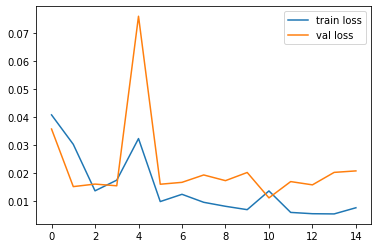

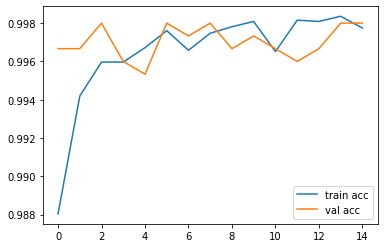

<Figure size 432x288 with 0 Axes>

In [32]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [33]:
from tensorflow.keras.models import load_model

model.save('modelanimalface_resNet.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# **Making Predictions**

In [34]:
y_pred = model.predict(test_set)

In [35]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 2, 2, ..., 1, 2, 1])

In [39]:
def predict_face(img):
    plt.figure(figsize=(40,8))
    print()
    print('----------Animal classification via Face----------')
    print()
    x=image.img_to_array(img)
    x=x/255
    plt.imshow(img)
    x=np.expand_dims(x,axis=0)
    #img_data=preprocess_input(x)
    print("The Animal is being recognized under the class:")

    print(classes[np.argmax(model.predict(x))])

In [37]:
classes=["CAT", "DOG","WILD"]


----------Animal classification via Face----------

The Animal is being recognized under the class:
CAT


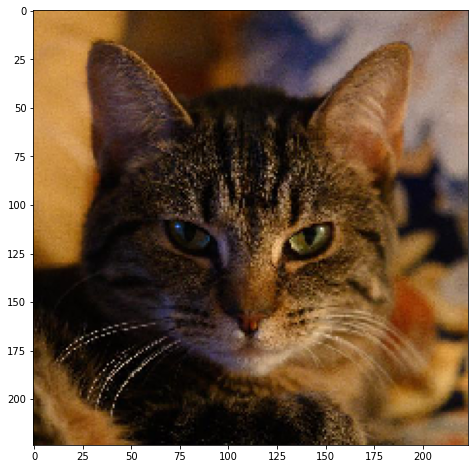

In [40]:
im=image.load_img('/content/afhq/val/cat/flickr_cat_000011.jpg',target_size=(224,224))
predict_face(im)


----------Animal classification via Face----------

The Animal is being recognized under the class:
CAT


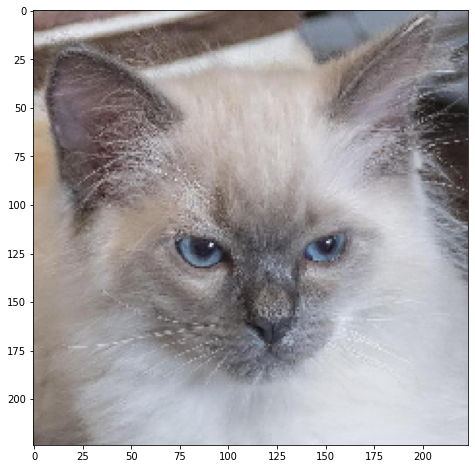

In [41]:
im2=image.load_img('/content/afhq/val/cat/flickr_cat_000162.jpg',target_size=(224,224))
predict_face(im2)


----------Animal classification via Face----------

The Animal is being recognized under the class:
CAT


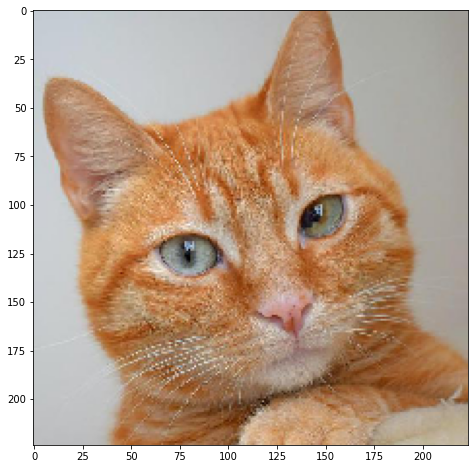

In [42]:
im3=image.load_img('/content/afhq/val/cat/pixabay_cat_000117.jpg',target_size=(224,224))
predict_face(im3)


----------Animal classification via Face----------

The Animal is being recognized under the class:
DOG


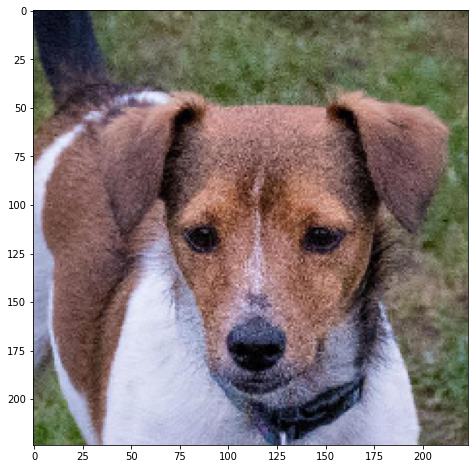

In [43]:
im4=image.load_img('/content/afhq/val/dog/flickr_dog_000160.jpg',target_size=(224,224))
predict_face(im4)


----------Animal classification via Face----------

The Animal is being recognized under the class:
DOG


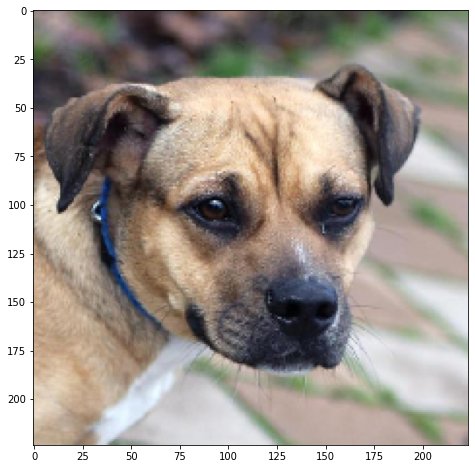

In [45]:

im5=image.load_img('/content/afhq/val/dog/flickr_dog_000174.jpg',target_size=(224,224))
predict_face(im5)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


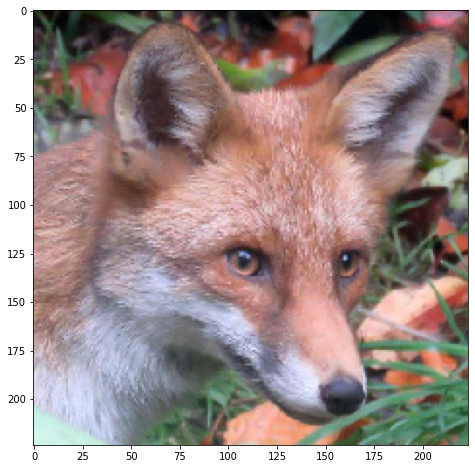

In [46]:
im5=image.load_img('/content/afhq/val/wild/flickr_wild_000125.jpg',target_size=(224,224))
predict_face(im5)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


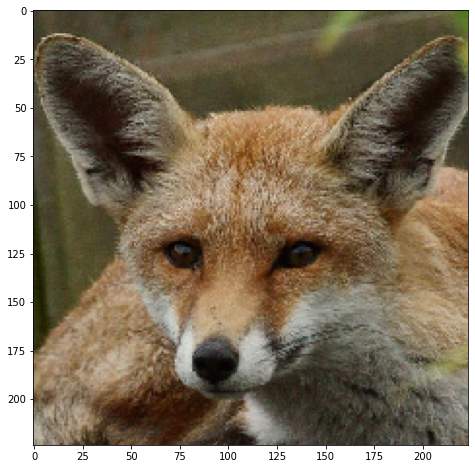

In [47]:
im5=image.load_img('/content/afhq/val/wild/flickr_wild_000090.jpg',target_size=(224,224))
predict_face(im5)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


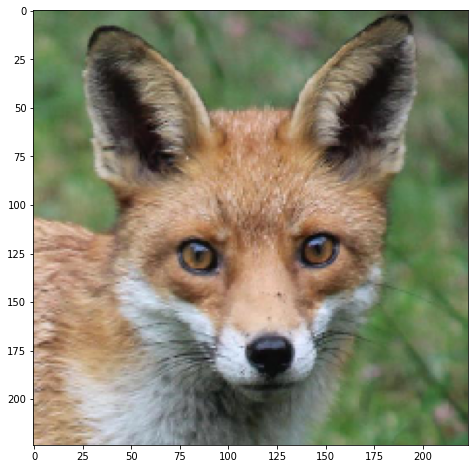

In [48]:
im5=image.load_img('/content/afhq/val/wild/flickr_wild_000063.jpg',target_size=(224,224))
predict_face(im5)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


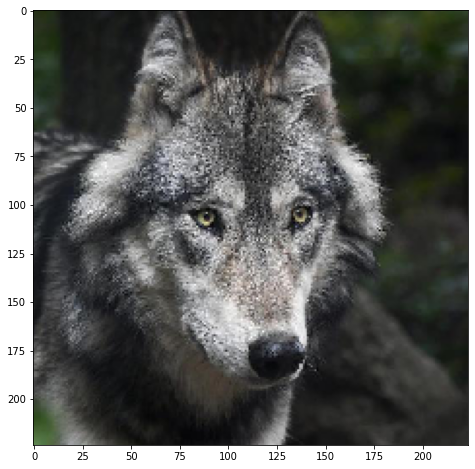

In [49]:
im6=image.load_img('/content/afhq/val/wild/pixabay_wild_000613.jpg',target_size=(224,224))
predict_face(im6)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


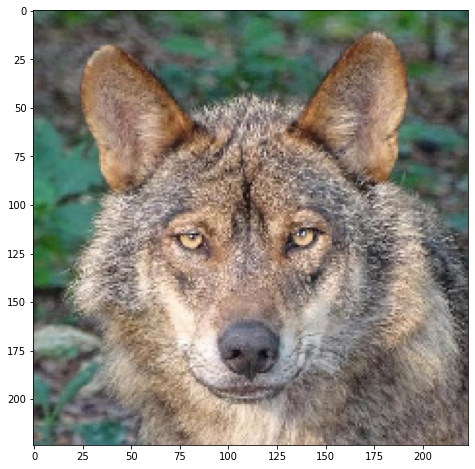

In [50]:
im6=image.load_img('/content/afhq/val/wild/pixabay_wild_000629.jpg',target_size=(224,224))
predict_face(im6)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


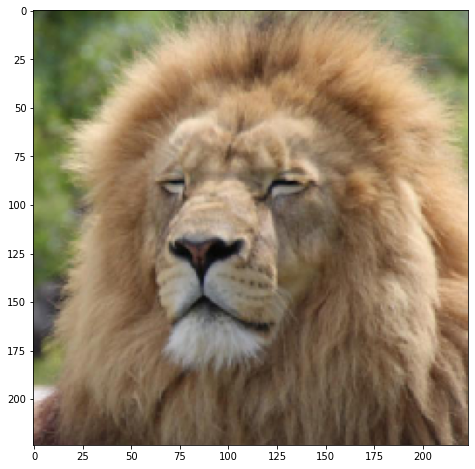

In [52]:
im6=image.load_img('/content/afhq/val/wild/pixabay_wild_001224.jpg',target_size=(224,224))
predict_face(im6)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


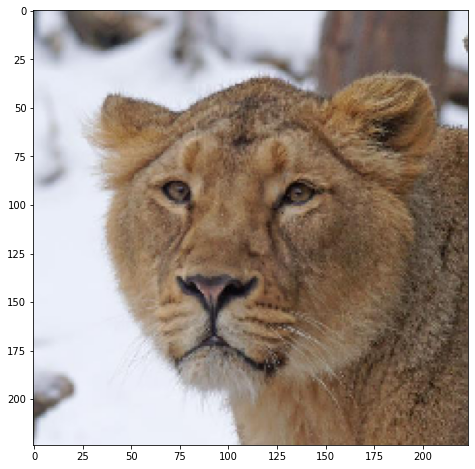

In [53]:
im6=image.load_img('/content/afhq/val/wild/pixabay_wild_001112.jpg',target_size=(224,224))
predict_face(im6)


----------Animal classification via Face----------

The Animal is being recognized under the class:
WILD


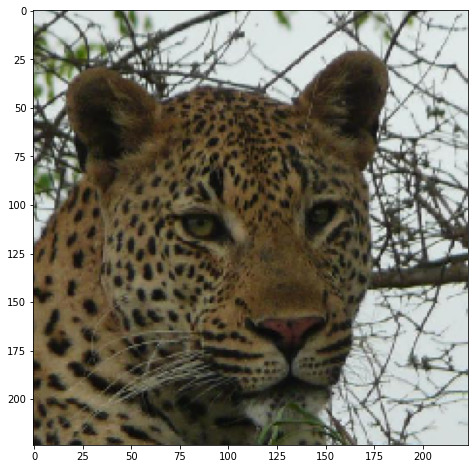

In [54]:
im6=image.load_img('/content/afhq/val/wild/pixabay_wild_000994.jpg',target_size=(224,224))
predict_face(im6)